# Solar ANN 

### Load and preprocess data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Ml/getData/combined_fuel_weather_data.csv')
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
solar_data = data[['BeginDate', 'Solar','Previous_Day','Previous_Year']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_20364\3966809150.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Ml/getData/combined_fuel_weather_data.csv')


In [2]:
from bisect import bisect_left

def get_previous_day_Solar(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Solar'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [3]:
from bisect import bisect_left

def get_two_days_before_Solar(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Solar'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [4]:
from bisect import bisect_left

def get_previous_year_Solar(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Solar'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [5]:
# Large computation 
data['Previous_Year_Solar'] = data.apply(get_previous_year_Solar, axis=1, reference_df=solar_data)

In [6]:
cutoff_date = pd.to_datetime("2023-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Solar','Previous_Day','Previous_Year']].copy()

In [7]:


usable_data['Previous_Day_Solar'] = usable_data.apply(get_previous_day_Solar, axis=1, reference_df=solar_data2)
usable_data['Previous_2Day_Solar'] = usable_data.apply(get_two_days_before_Solar, axis=1, reference_df=solar_data2)


In [8]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Month'] = usable_data['BeginDate'].dt.month
usable_data['Year'] = usable_data['BeginDate'].dt.year
features = usable_data[['Month','Year','Previous_Year_Solar','Previous_2Day_Solar','Sum','temp', 'humidity', 'precip', 'uvindex', 'cloudcover', 'solarradiation','Previous_Day_Solar','solarenergy','Hour_of_Day','dew','dew','snow','snowdepth','windspeed','windgust']]

# Useless Features , 'winddir',,
target = usable_data['Solar']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (98288, 20)
Target shape:  (98288,)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=70, restore_best_weights=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [13]:
from tensorflow.keras import regularizers

from tensorflow.keras.layers import LeakyReLU
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(X_train, y_train, epochs=100, validation_split=0.15, batch_size=128, callbacks=[early_stopping, lr_scheduler])

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


Epoch 1/100


C:\Users\Avishai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Avishai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


523/523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 142.9421 - val_loss: 125.0553 - learning_rate: 0.0010
Epoch 2/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 113.5530 - val_loss: 82.8211 - learning_rate: 0.0010
Epoch 3/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 76.7705 - val_loss: 49.9451 - learning_rate: 0.0010
Epoch 4/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 51.9461 - val_loss: 42.6166 - learning_rate: 0.0010
Epoch 5/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 44.6980 - val_loss: 31.7152 - learning_rate: 0.0010
Epoch 6/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 42.4597 - val_loss: 30.7267 - learning_rate: 0.0010
Epoch 7/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 42.3144 - val_loss: 34.7903 - learning_rate: 0.0010
Epoch 8/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 40.8522 - val_loss: 28.7852 - learning_rate: 0.0010
Epoch 9/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 40.6914 - val_loss: 28.1574 - learning_rate:

### Analysis

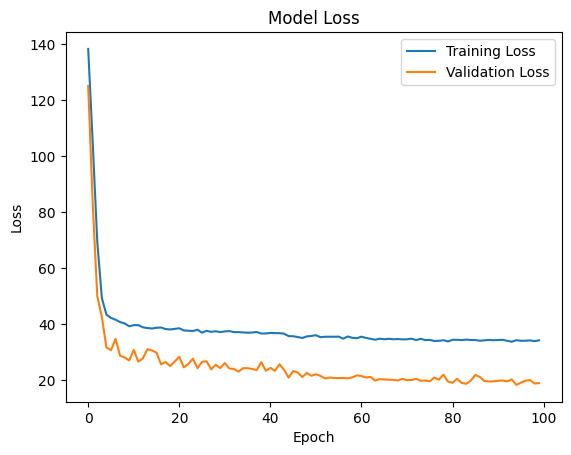

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [15]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicted Solar Energy Ouput: [389.499755859375, 4.790428161621094, 451.4405517578125, 273.0603942871094, 14.690191268920898, 79.19918060302734, 3.6060116291046143, 3.736204147338867, 4.502146244049072, 4.673709392547607, 0.0, 32.418819427490234, 1.7009252309799194, 2.2017855644226074, 1.773118257522583, 609.8171997070312, 318.5538024902344, 1.8756837844848633, 59.611183166503906, 391.82379150390625]
Actual Solar Energy Output: [355.   8. 448. 272.  20.  47.   7.   1.  16.   0.   0.  39.   0.   2.
   0. 666. 234.   0.  41. 365.]


In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 17.931025560277078
Mean Squared Error (MSE): 1210.1358320517943
Root Mean Squared Error (RMSE): 34.78700665552864
Percent Error (PERR): 0.12257624689947325


### Save model

In [17]:
model.save('SolarModel.h5')